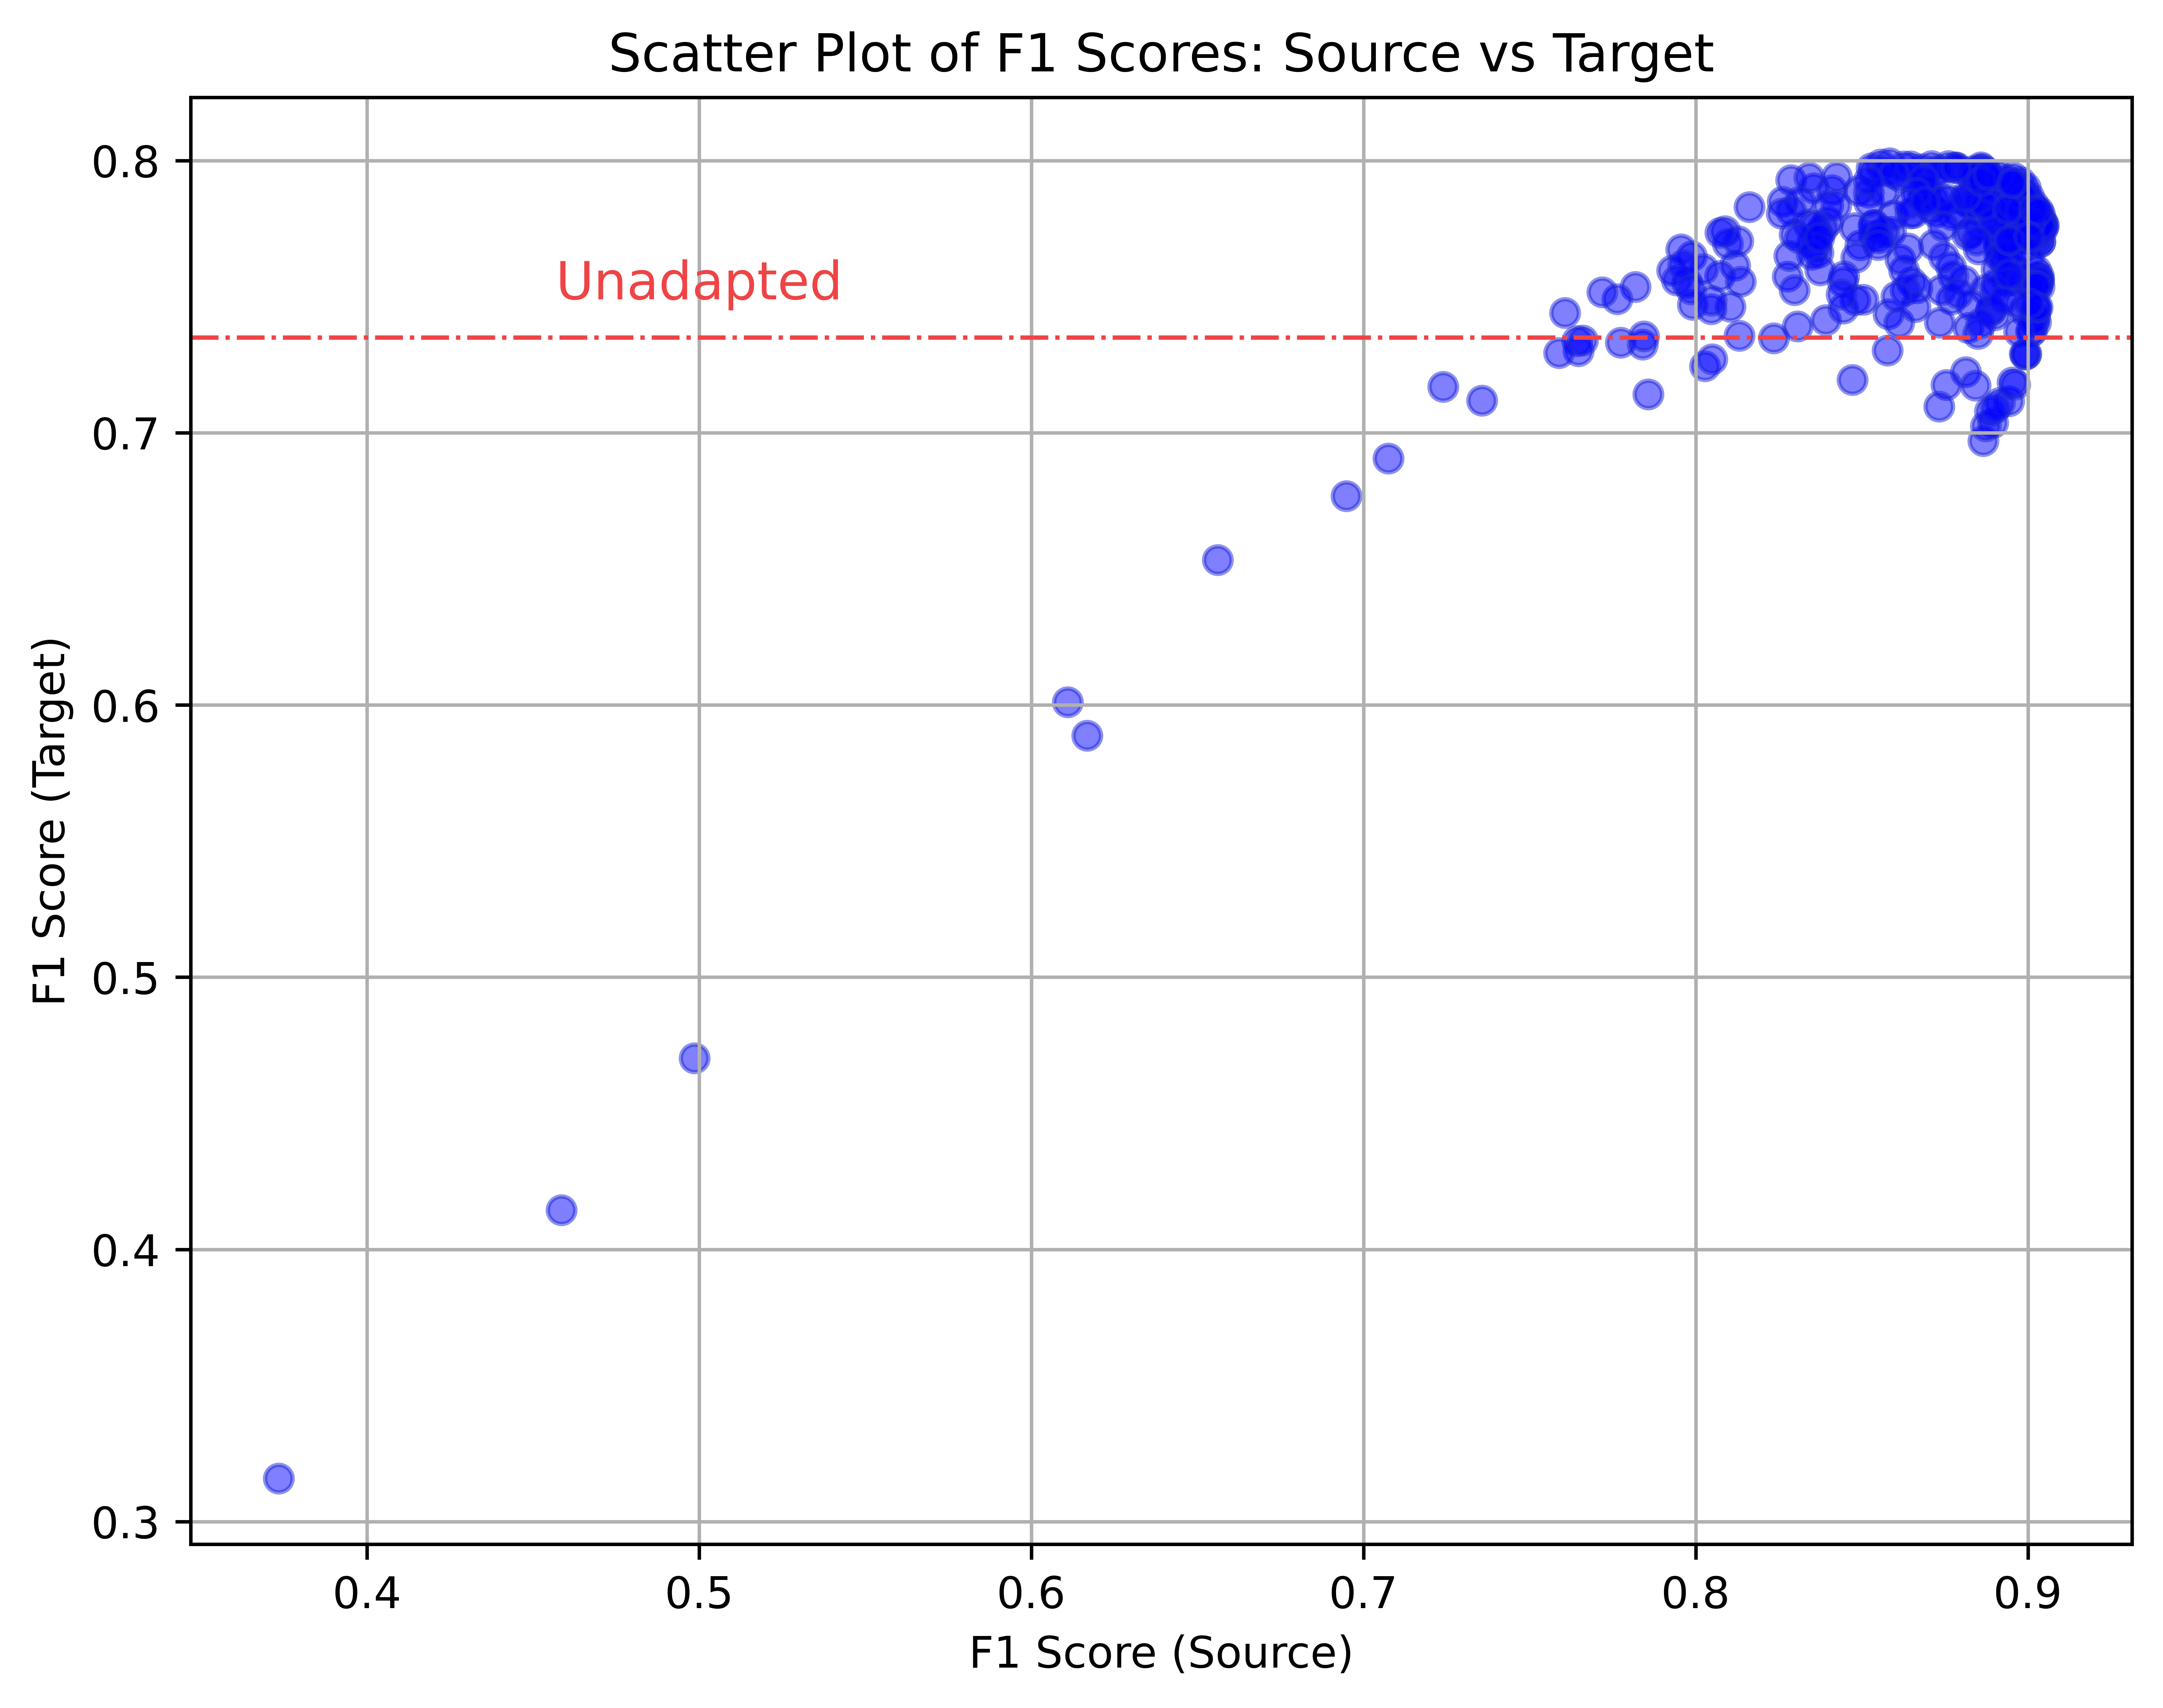

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/home/amarinai/DeepLearningThesis/Results/Unet_FDA_RANDOM/results.csv')

# Create a scatter plot of f1_source vs. f1_target
plt.figure(figsize=(8, 6), dpi=1000)
plt.scatter(df['f1_source'], df['f1_target'], color='blue', alpha=0.5, edgecolor='#1e28d8', s=40)

# Add a horizontal red line at y=0.74 with dash-dot style
plt.axhline(y=0.735, color='#ef4446', linestyle='-.', linewidth=1)

# Add text to label the line, positioned inside the plot
plt.text(0.5, 0.745, 'Unadapted', color='#ef4446', fontsize=12, verticalalignment='bottom', horizontalalignment='center')

# Add labels and title
plt.xlabel('F1 Score (Source)')
plt.ylabel('F1 Score (Target)')
plt.title('Scatter Plot of F1 Scores: Source vs Target')

# Show plot grid
plt.grid(True)

# Display the plot
plt.show()


In [42]:
percentage_above_threshold = (df['f1_target'] > 0.735).mean() * 100
print(f"Percentage of rows where F1 Score (Target) > 0.735: {percentage_above_threshold:.2f}%")

Percentage of rows where F1 Score (Target) > 0.735: 87.33%


In [44]:
import lmdb
import matplotlib.pyplot as plt
import pickle
import os
import lmdb
import json
import pickle
import shutil
import argparse

import numpy as np
import pandas as pd
import tensorflow as tf
import wandb
import yaml
import csv

from numba import cuda
import time

from config_manager import TrainConfiguration, TrainDAConfiguration
from data import TrainingDataset_DA, TrainingDataset, TrainingDataset_DA_gamma
from losses import FramedCrossentropy3D
from metrics import Precision, Recall, F1
from models import UNetNoSkip_DA, UNet_DA_Pixelwise, UNetSkipHead, UNetSkipHead_2, UNetSkipHead_3, UNetSkipHead_4, ResUNet_DA, ResUNet
from localizers import BlobDoG
from utils.models import predict
from utils.data import get_input_tf, get_gt_as_numpy
from utils.base import evaluate_df
#from callbacksDA import LambdaSchedulerGRL
import warnings
from data.augmentation import gamma_tf
from scheduler import CustomCosineDecayRestarts



In [30]:
gpu=1

gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[gpu], "GPU")
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
tf.config.experimental.set_memory_growth(gpus[gpu], True)  #non occupa tutta la memoria subito

config_file = "/home/amarinai/DeepLearningThesis/BCFind-v2/train_config_FDA.yaml"

conf = TrainDAConfiguration(config_file)

with open(config_file, 'r') as f:
    data = yaml.load(f, Loader=yaml.BaseLoader)


trainer = Trainer()    

train_tiff_files, train_marker_files = get_inputs_target_paths(
    conf.source.train_tif_dir, conf.source.train_gt_dir
)

test_tiff_files, test_marker_files = get_inputs_target_paths(
    conf.source.test_tif_dir, conf.source.test_gt_dir
)

train_tiff_files_target = get_inputs_target_paths_no_gt(conf.target.train_tif_dir)

test_tiff_files_target = get_inputs_target_paths_no_gt(conf.target.test_tif_dir)


trainer.make_unet_data_FDA(
    train_inputs=train_tiff_files,
    train_targets=train_marker_files,
    train_inputs_target = train_tiff_files_target,
    dim_resolution=conf.source.dim_resolution,
    input_shape=conf.unet.input_shape,
    augmentations=conf.data_aug.op_args,
    augmentations_prob=conf.data_aug.op_probs,
    batch_size=conf.unet.batch_size,
    val_inputs=None,
    val_targets=None,
    use_lmdb=False,
    preprocess_kwargs=conf.preproc,
    preprocess_kwargs_target=conf.preproct
)



{'clip': 'bit', 'clip_value': 15, 'center': None, 'center_value': None, 'scale': 'bit', 'scale_value': 15}
{'clip': 'bit', 'clip_value': 15, 'center': None, 'center_value': None, 'scale': 'bit', 'scale_value': 15}
beforeeee
<_ShuffleDataset element_spec=TensorSpec(shape=(2, 80, 120, 120), dtype=tf.float32, name=None)>
aaa
<_ParallelMapDataset element_spec=TensorSpec(shape=(2, 80, 120, 120, 1), dtype=tf.float32, name=None)>
<_ParallelMapDataset element_spec=TensorSpec(shape=(2, 80, 120, 120, 1), dtype=tf.float32, name=None)>
<_ParallelMapDataset element_spec=TensorSpec(shape=(2, 80, 120, 120, 1), dtype=tf.float32, name=None)>
cis siamo


In [41]:
def low_freq_mutate_np(amp_src, amp_trg, L, lmbda):
    amp_src = tf.signal.fftshift(amp_src, axes=(0, 1, 2))
    amp_trg = tf.signal.fftshift(amp_trg, axes=(0, 1, 2))

    amp_src1 = amp_src
    amp_trg1 = amp_trg

    d, h, w = amp_src.shape
    b = (np.floor(np.amin((h,w,d))*L)).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)
    c_z = np.floor(d/2.0).astype(int)

    print(b,d,h,w)
    h1, h2 = c_h - b, c_h + b + 1
    w1, w2 = c_w - b, c_w + b + 1
    d1, d2 = c_z - b//2, c_z + b//2 + 1

    amp_src = amp_src.numpy()
    amp_trg = amp_trg.numpy()
    amp_src[d1:d2,h1:h2,w1:w2] = lmbda * amp_trg[d1:d2,h1:h2,w1:w2] + (1-lmbda) * amp_src[d1:d2,h1:h2,w1:w2]
    amp_src = tf.convert_to_tensor(amp_src)
    amp_src = tf.signal.ifftshift(amp_src, axes=(0, 1, 2))
    return amp_src, amp_src1, amp_trg1


def FDA_source_to_target_np(src_img, trg_img, L, lmbda):
    fft_src = tf.signal.fft3d(tf.cast(src_img, tf.complex64))
    fft_trg = tf.signal.fft3d(tf.cast(trg_img, tf.complex64))

    # Get amplitude and phase of source and target
    amp_src, pha_src = tf.abs(fft_src), tf.math.angle(fft_src)
    amp_trg, _ = tf.abs(fft_trg), tf.math.angle(fft_trg)

    # mutate the amplitude part of source with target
    amp_src_, amp_src1, amp_trg1 = low_freq_mutate_np(amp_src, amp_trg, L, lmbda)

    # mutated fft of source
    fft_src_ = tf.complex(amp_src_, tf.zeros_like(amp_src_)) * tf.exp(tf.complex(tf.zeros_like(pha_src), pha_src))

    # Perform inverse FFT to get the transformed source image
    src_in_trg = tf.signal.ifft3d(fft_src_)

    # Return the transformed image and label
    return tf.math.real(src_in_trg), amp_src1, amp_trg1


def apply_fda_transformation_img_tf(src_img, y, trg_img, L, lmbda):
    ret, amp_src, amp_trg = FDA_source_to_target_np(src_img, trg_img, L, lmbda)

    return tf.convert_to_tensor(ret), y, amp_src, amp_trg

In [40]:
import random
import tifffile
import os

gpu=1

gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[gpu], "GPU")

base_path = "/home/amarinai/Data/Broca_old_l48_long/Tiff_files/Train"
fnames = os.listdir(base_path)
trg_path = random.choice(fnames)
print(trg_path)

path = f"{base_path}/{trg_path}"
trg_img = tifffile.imread(path)

trg_img[trg_img>2**15] = 2**15
trg_img = trg_img/2**15

base_path_src = "/home/amarinai/Data/Broca_I45_95crops/Tiff_files/Train"
fnames = os.listdir(base_path_src)
path = random.choice(fnames)
print(path)

path = f"{base_path_src}/{path}"
img = tifffile.imread(path)

img[img>2**15] = 2**15
img = img/2**15

img = tf.convert_to_tensor(img)
trg_img = tf.convert_to_tensor(trg_img)


slice_2_pos_61_3597_3013_dim_50_100_100.tif
crop_53.tif


In [42]:
img_modifier, _, amp_src, amp_trg  = apply_fda_transformation_img_tf(img, 0, trg_img, L=0.15, lmbda=0.8)

7 50 100 100


Plot the spectrum amplitude


Text(0.5, 1.0, 't ')

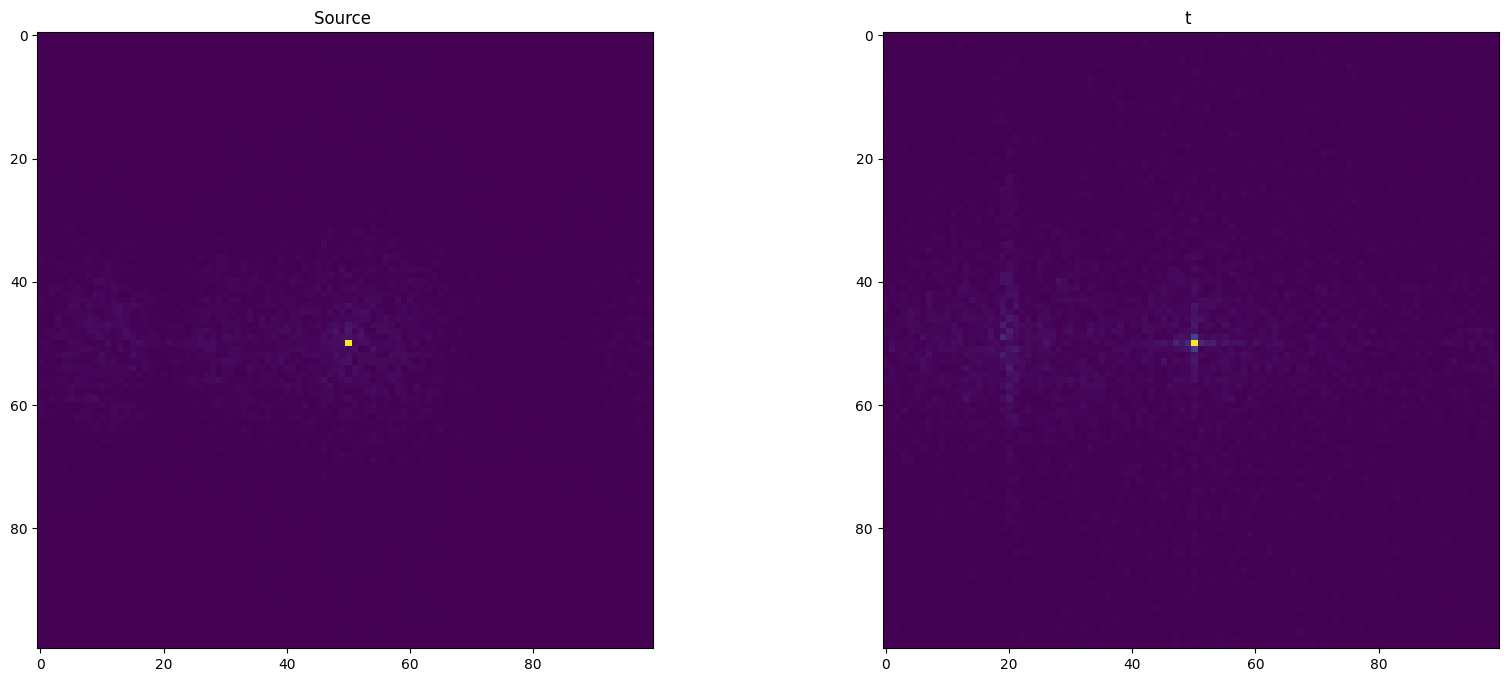

In [43]:
plt.figure(figsize=[20,8])

plt.subplot(121)
plt.imshow(amp_src[10])
plt.title("Source ")
plt.subplot(122)
plt.imshow(amp_trg[10])
plt.title("t ")


Text(0.5, 1.0, 'Target not normalized')

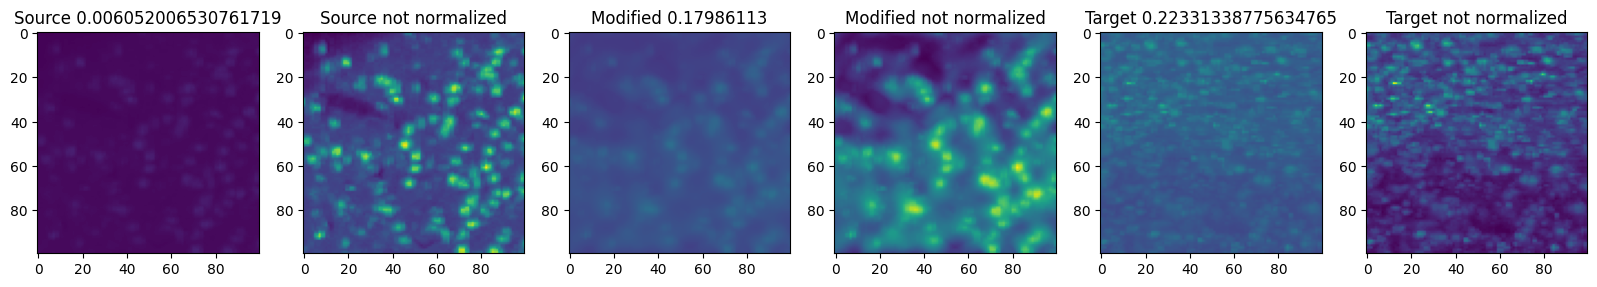

In [44]:
plt.figure(figsize=[20,8])


plt.subplot(161)
plt.imshow(img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Source " + str(img.numpy().mean()))


plt.subplot(162)
plt.imshow(img[...].numpy().max(0))
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Modified " + str(img_modifier.numpy().mean()))
plt.subplot(164)
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Target " + str(trg_img.numpy().mean()))

plt.subplot(166)
plt.imshow(trg_img[...].numpy().max(0))
plt.title("Target not normalized")



Try adding batch and channels

In [46]:
aug_img = tf.expand_dims(img, 0)
aug_img = tf.expand_dims(aug_img, -1)
aug_trg_img = tf.expand_dims(trg_img, 0)
aug_trg_img = tf.expand_dims(aug_trg_img, -1)
print(aug_img.shape)
print(aug_trg_img.shape)

(1, 50, 100, 100, 1)
(1, 50, 100, 100, 1)


In [65]:
import tensorflow as tf
import numpy as np

def low_freq_mutate_np(amp_src, amp_trg, L, lmbda):
    # Shift along the spatial dimensions (depth, height, width)
    amp_src = tf.signal.fftshift(amp_src, axes=(2, 3, 4))
    amp_trg = tf.signal.fftshift(amp_trg, axes=(2, 3, 4))
    print(amp_src.shape)

    batch_size, c, d, h, w = amp_src.shape
    b = (np.floor(np.amin((h, w, d)) * L)).astype(int)

    # Central points in depth, height, width
    c_h = np.floor(h / 2.0).astype(int)
    c_w = np.floor(w / 2.0).astype(int)
    c_z = np.floor(d / 2.0).astype(int)

    h1, h2 = c_h - b, c_h + b + 1
    w1, w2 = c_w - b, c_w + b + 1
    d1, d2 = c_z - b // 2, c_z + b // 2 + 1

    amp_src_np = amp_src.numpy()
    amp_trg_np = amp_trg.numpy()

    # Apply the low-frequency mutation for each batch (no need to iterate over channels)
    for batch in range(batch_size):
        for channel in range(c):  # Channel-specific mutation
            amp_src_np[batch, channel, d1:d2, h1:h2, w1:w2] = (
                lmbda * amp_trg_np[batch, channel, d1:d2, h1:h2, w1:w2] +
                (1 - lmbda) * amp_src_np[batch, channel, d1:d2, h1:h2, w1:w2]
            )

    # Convert back to tensor
    amp_src = tf.convert_to_tensor(amp_src_np)

    # Inverse fftshift along the spatial dimensions (1, 2, 3)
    amp_src = tf.signal.ifftshift(amp_src, axes=(2, 3, 4))
    
    return amp_src

def FDA_source_to_target_np(src_img, trg_img, L, lmbda):
    # Transpose to move spatial dimensions (depth, height, width) to the innermost position
    src_img_transposed = tf.transpose(src_img, perm=[0, 4, 1, 2, 3])  # (batch, channels, depth, height, width)
    trg_img_transposed = tf.transpose(trg_img, perm=[0, 4, 1, 2, 3])  # Same for target image

    # Perform FFT along the spatial dimensions (depth, height, width)
    fft_src = tf.signal.fft3d(tf.cast(src_img_transposed, tf.complex64))
    fft_trg = tf.signal.fft3d(tf.cast(trg_img_transposed, tf.complex64))

    # Get amplitude and phase of source and target
    amp_src, pha_src = tf.abs(fft_src), tf.math.angle(fft_src)
    amp_trg, _ = tf.abs(fft_trg), tf.math.angle(fft_trg)

    # Mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np(amp_src, amp_trg, L, lmbda)

    # Mutated FFT of source
    fft_src_ = tf.complex(amp_src_, tf.zeros_like(amp_src_)) * tf.exp(tf.complex(tf.zeros_like(pha_src), pha_src))

    # Perform inverse FFT to get the transformed source image
    src_in_trg = tf.signal.ifft3d(fft_src_)

    # Transpose back to original format (batch, depth, height, width, channels)
    src_in_trg = tf.transpose(src_in_trg, perm=[0, 2, 3, 4, 1])

    # Return the transformed image
    return tf.math.real(src_in_trg)

def apply_fda_transformation_img_tf(src_img, y, trg_img, L, lmbda):
    # Assumes src_img and trg_img have shape (batch_size, depth, height, width, channels)
    ret = FDA_source_to_target_np(src_img, trg_img, L, lmbda)

    return tf.convert_to_tensor(ret), y


In [66]:
img_modifier, _  = apply_fda_transformation_img_tf(aug_img, 0, aug_trg_img, L=0.15, lmbda=0.8)

(1, 1, 50, 100, 100)


In [49]:
img_modifier.shape

TensorShape([1, 50, 100, 100, 1])

Text(0.5, 1.0, 'Modified 0.17986113')

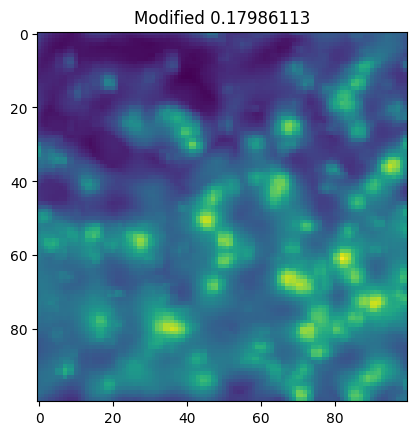

In [67]:
plt.imshow(img_modifier[0,...,0].numpy().max(0))
plt.title("Modified " + str(img_modifier.numpy().mean()))

Text(0.5, 1.0, 'Modified 0.17986113')

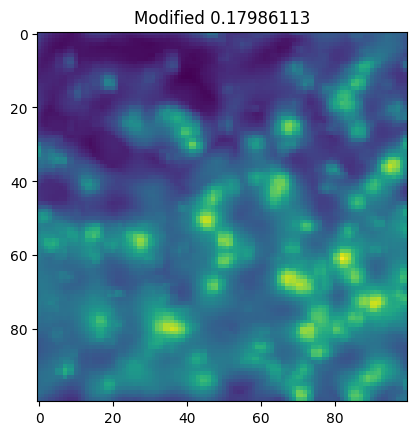

In [45]:
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified " + str(img_modifier.numpy().mean()))

Some experiments

Text(0.5, 1.0, 'Target not normalized')

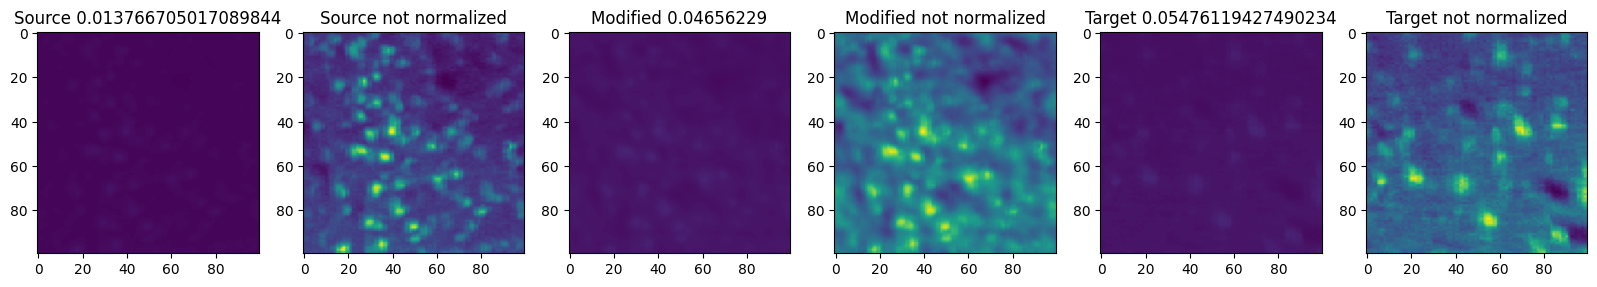

In [45]:
plt.figure(figsize=[20,8])

z0 = 10
plt.subplot(161)
plt.imshow(img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Source " + str(img.numpy().mean()))


plt.subplot(162)
plt.imshow(img[...].numpy()[z0])
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Modified " + str(img_modifier.numpy().mean()))
plt.subplot(164)
plt.imshow(img_modifier[...].numpy()[z0])
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Target " + str(trg_img.numpy().mean()))

plt.subplot(166)
plt.imshow(trg_img[...].numpy()[z0])
plt.title("Target not normalized")

Text(0.5, 1.0, 'Target not normalized')

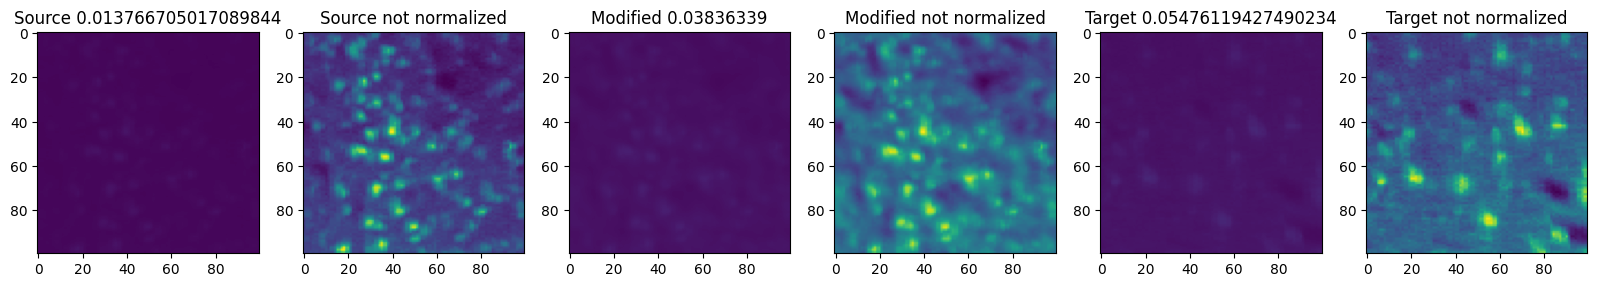

In [48]:
plt.figure(figsize=[20,8])

z0 = 10
plt.subplot(161)
plt.imshow(img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Source " + str(img.numpy().mean()))


plt.subplot(162)
plt.imshow(img[...].numpy()[z0])
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Modified " + str(img_modifier.numpy().mean()))
plt.subplot(164)
plt.imshow(img_modifier[...].numpy()[z0])
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy()[z0], vmin=0, vmax=1)
plt.title("Target " + str(trg_img.numpy().mean()))

plt.subplot(166)
plt.imshow(trg_img[...].numpy()[z0])
plt.title("Target not normalized")

In [18]:
trg_img[...].numpy().max()

0.320465087890625

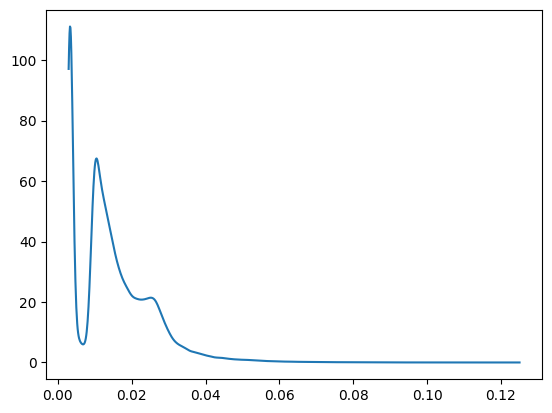

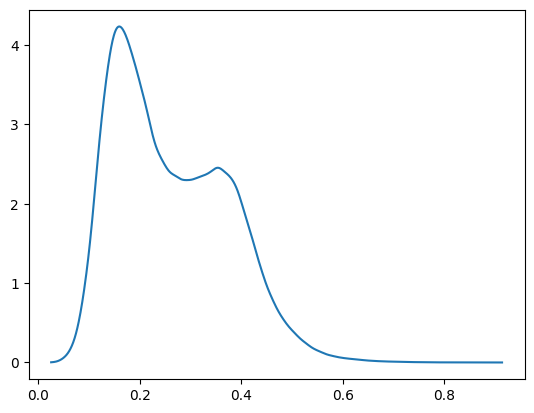

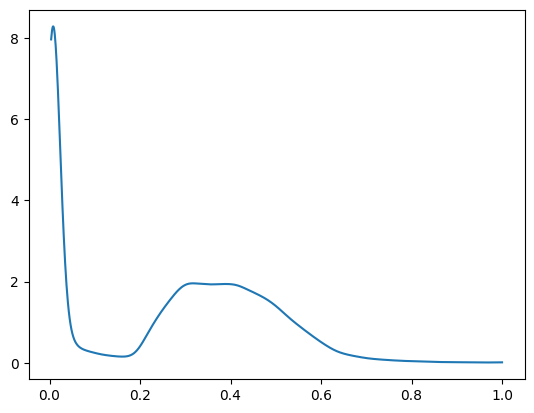

In [383]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(img.numpy().flatten())

x_values = np.linspace(min(img.numpy().flatten()), max(img.numpy().flatten()), 1000)

plt.plot(x_values, kde(x_values))
plt.show()

kde = gaussian_kde(img_modifier.numpy().flatten())

x_values = np.linspace(min(img_modifier.numpy().flatten()), max(img_modifier.numpy().flatten()), 1000)

plt.plot(x_values, kde(x_values))
plt.show()

kde = gaussian_kde(trg_img.numpy().flatten())

x_values = np.linspace(min(trg_img.numpy().flatten()), max(trg_img.numpy().flatten()), 1000)

plt.plot(x_values, kde(x_values))
plt.show()





(50, 100, 100)


Text(0.5, 1.0, 'Target not normalized')

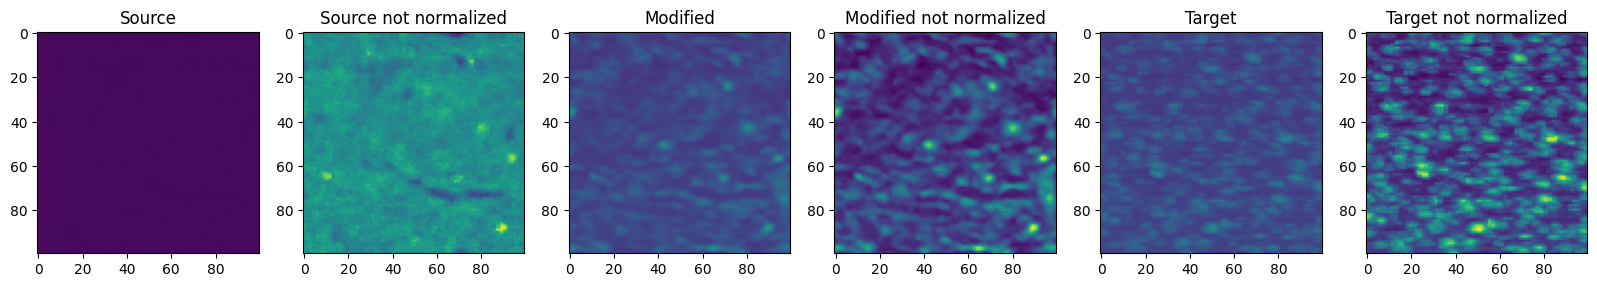

In [330]:
plt.figure(figsize=[20,8]) #


plt.subplot(161)
plt.imshow(img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Source")


plt.subplot(162)
plt.imshow(img[...].numpy().max(0))
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Modified")
plt.subplot(164)
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy().max(0), vmin=0, vmax=1)
plt.title("Target")

plt.subplot(166)
plt.imshow(trg_img[...].numpy().max(0))
plt.title("Target not normalized")

(50, 100, 100)


Text(0.5, 1.0, 'Target not normalized')

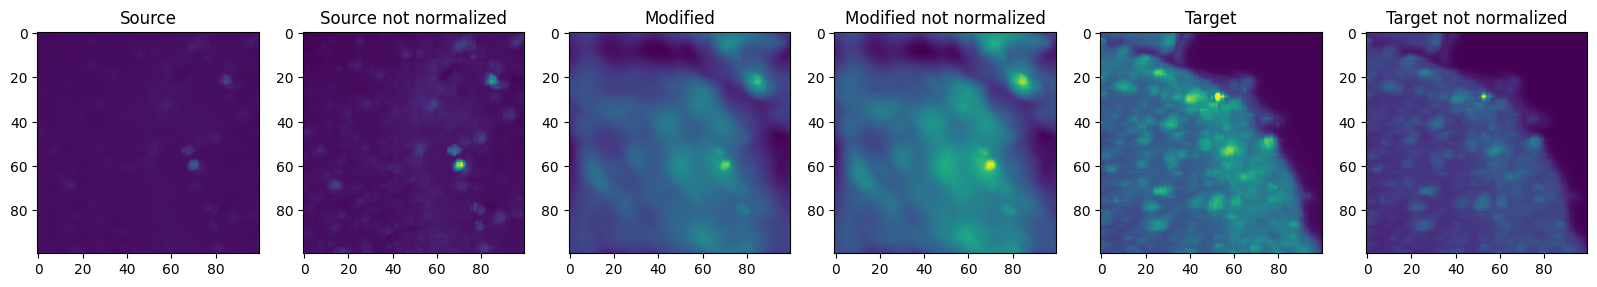

In [314]:
print(img.shape)   #L = 0.1

plt.figure(figsize=[20,8])


plt.subplot(161)
plt.imshow(img[...].numpy().max(0), vmin=0, vmax=0.5)
plt.title("Source")


plt.subplot(162)
plt.imshow(img[...].numpy().max(0))
plt.title("Source not normalized")
plt.subplot(163)
plt.imshow(img_modifier[...].numpy().max(0), vmin=0, vmax=0.5)
plt.title("Modified")
plt.subplot(164)
plt.imshow(img_modifier[...].numpy().max(0))
plt.title("Modified not normalized")

plt.subplot(165)
plt.imshow(trg_img[...].numpy().max(0), vmin=0, vmax=0.5)
plt.title("Target")

plt.subplot(166)
plt.imshow(trg_img[...].numpy().max(0))
plt.title("Target not normalized")


AttributeError: 'TrainConfiguration' object has no attribute 'source'

In [111]:
from train_FDA import Trainer
from train_FDA import get_inputs_target_paths, get_inputs_target_paths_no_gt

In [64]:
trainer.unet_train_data


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 80, 120, 120, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 80, 120, 120, 1), dtype=tf.float32, name=None))>

In [112]:
gpu=1

gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[gpu], "GPU")
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
tf.config.experimental.set_memory_growth(gpus[gpu], True)  #non occupa tutta la memoria subito

config_file = "/home/amarinai/DeepLearningThesis/BCFind-v2/train_config_FDA.yaml"

conf = TrainDAConfiguration(config_file)

with open(config_file, 'r') as f:
    data = yaml.load(f, Loader=yaml.BaseLoader)


trainer = Trainer()    

train_tiff_files, train_marker_files = get_inputs_target_paths(
    conf.source.train_tif_dir, conf.source.train_gt_dir
)

test_tiff_files, test_marker_files = get_inputs_target_paths(
    conf.source.test_tif_dir, conf.source.test_gt_dir
)

train_tiff_files_target = get_inputs_target_paths_no_gt(conf.target.train_tif_dir)

test_tiff_files_target = get_inputs_target_paths_no_gt(conf.target.test_tif_dir)


trainer.make_unet_data_FDA(
    train_inputs=train_tiff_files,
    train_targets=train_marker_files,
    train_inputs_target = train_tiff_files_target,
    dim_resolution=conf.source.dim_resolution,
    input_shape=conf.unet.input_shape,
    augmentations=conf.data_aug.op_args,
    augmentations_prob=conf.data_aug.op_probs,
    batch_size=conf.unet.batch_size,
    val_inputs=None,
    val_targets=None,
    use_lmdb=False,
    preprocess_kwargs=conf.preproc,
    preprocess_kwargs_target=conf.preproct
)



{'clip': 'bit', 'clip_value': 15, 'center': None, 'center_value': None, 'scale': 'bit', 'scale_value': 15}
{'clip': 'bit', 'clip_value': 15, 'center': None, 'center_value': None, 'scale': 'bit', 'scale_value': 15}
beforeeee
<_ShuffleDataset element_spec=TensorSpec(shape=(2, 80, 120, 120), dtype=tf.float32, name=None)>
aaa
<_ParallelMapDataset element_spec=TensorSpec(shape=(2, 80, 120, 120, 1), dtype=tf.float32, name=None)>
<_ParallelMapDataset element_spec=TensorSpec(shape=(2, 80, 120, 120, 1), dtype=tf.float32, name=None)>
<_ParallelMapDataset element_spec=TensorSpec(shape=(2, 80, 120, 120, 1), dtype=tf.float32, name=None)>
cis siamo


(10, 80, 120, 120, 1)


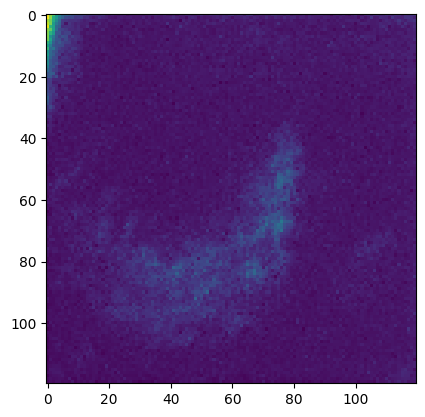

In [125]:
for step, data in enumerate(trainer.unet_train_data):
                print(data[0].shape)
                plt.imshow(data[0][0, ..., 0].numpy().max(0))
                
                break

In [1]:
import tifffile
import matplotlib.pyplot as plt

img = tifffile.imread("/tmp/I48_S06_fused.tiff")

(array([6.1449076e+07, 5.6084305e+07, 5.8284289e+07, 5.3361579e+07,
        5.2136901e+07, 5.4406385e+07, 4.9910826e+07, 5.2222183e+07,
        4.8044440e+07, 4.7156966e+07, 4.9482570e+07, 4.5672231e+07,
        4.5106857e+07, 4.7744123e+07, 4.4332191e+07, 4.6694160e+07,
        4.3098438e+07, 4.2640685e+07, 4.4589752e+07, 4.1321987e+07,
        4.3816912e+07, 4.0148962e+07, 3.9480254e+07, 4.1795839e+07,
        3.9076637e+07, 3.8992469e+07, 4.1491829e+07, 3.8801246e+07,
        4.1288421e+07, 3.8679377e+07, 3.8648708e+07, 4.1180625e+07,
        3.8591455e+07, 4.1126636e+07, 3.8547944e+07, 3.8521179e+07,
        4.1069658e+07, 3.8515691e+07, 3.8480275e+07, 4.1087469e+07,
        3.8489653e+07, 4.0988719e+07, 3.8402536e+07, 3.8432912e+07,
        4.0959718e+07, 3.8377817e+07, 4.0859442e+07, 3.8281386e+07,
        3.8209536e+07, 4.0730026e+07, 3.8137327e+07, 3.8071109e+07,
        4.0510166e+07, 3.7919584e+07, 4.0426527e+07, 3.7753576e+07,
        3.7657635e+07, 4.0117299e+07, 3.7461688e

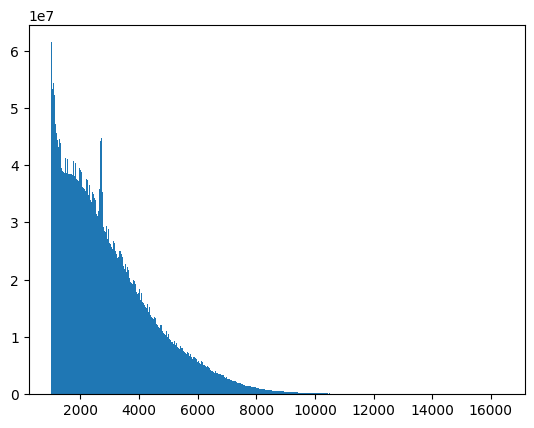

In [4]:
import matplotlib.pyplot as plt

plt.hist(img.flatten(), bins=1000, range=[1000, 2**14])

In [ ]:
img = img.max(0)
plt.imshow(img)

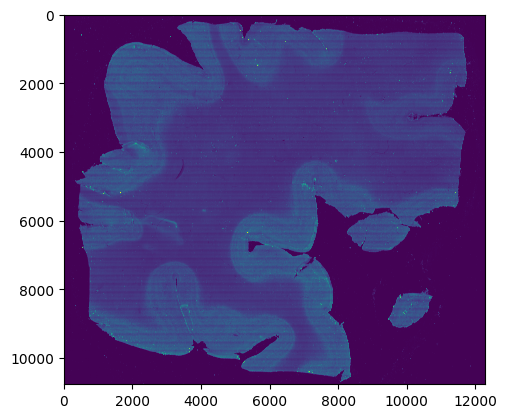

In [70]:
plt.imshow(img, vmin=0, vmax=2**15)

In [5]:
import pathlib
import os
import tifffile 
import pathlib
from pyometiff import OMETIFFReader
import random

tiff_ome_path = '/home/amarinai/Data/I45_unsupervised/I45_slice10_fused.ome.tif'
path = pathlib.Path(tiff_ome_path)  # '/home/amarinai/Data/I45_slice10_fused.ome.tif'

# Initialize the OME-TIFF reader and read the image
reader = OMETIFFReader(fpath=path)
print("preparing to read... this will take a few minutes")
img_to_crop, _, _ = reader.read()

preparing to read... this will take a few minutes
Key not found: list index out of range
Key not found: list index out of range
key not found list index out of range
Key not found: list index out of range


(array([1.668445e+06, 1.220713e+06, 1.193720e+06, 1.170777e+06,
        1.147763e+06, 1.124040e+06, 1.101854e+06, 1.081719e+06,
        1.059849e+06, 1.039553e+06, 1.357682e+06, 9.941050e+05,
        9.754120e+05, 9.557290e+05, 9.385410e+05, 9.219540e+05,
        9.023870e+05, 8.865320e+05, 8.723130e+05, 8.534370e+05,
        1.117137e+06, 8.197490e+05, 8.065700e+05, 7.917300e+05,
        7.763630e+05, 7.660060e+05, 7.515710e+05, 7.381740e+05,
        7.256150e+05, 7.131130e+05, 7.003700e+05, 9.172220e+05,
        6.749920e+05, 6.635960e+05, 6.535030e+05, 6.424910e+05,
        6.324530e+05, 6.234860e+05, 6.131380e+05, 6.021820e+05,
        5.955530e+05, 7.750300e+05, 5.734200e+05, 5.638150e+05,
        5.565560e+05, 5.475320e+05, 5.398180e+05, 5.307380e+05,
        5.225770e+05, 5.165430e+05, 5.093530e+05, 5.015860e+05,
        6.552790e+05, 4.855880e+05, 4.791180e+05, 4.716190e+05,
        4.642620e+05, 4.586990e+05, 4.522170e+05, 4.456500e+05,
        4.395910e+05, 4.345690e+05, 5.70

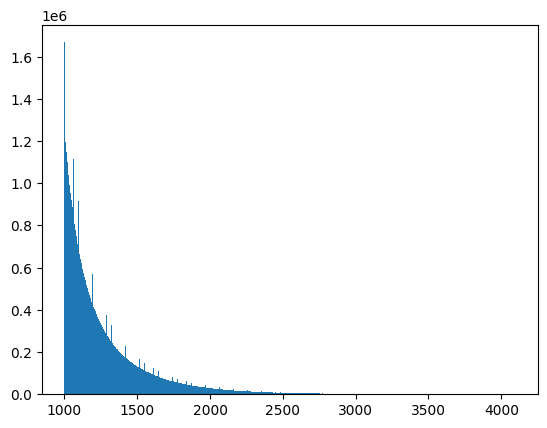

In [10]:
plt.hist(img_to_crop.flatten(), bins=1000, range=[1000, 2**12])

(array([1379., 1428., 1437., ...,    0.,    0.,    0.]),
 array([ 3000.    ,  3002.9768,  3005.9536, ..., 32762.0464, 32765.0232,
        32768.    ]),
 <BarContainer object of 10000 artists>)

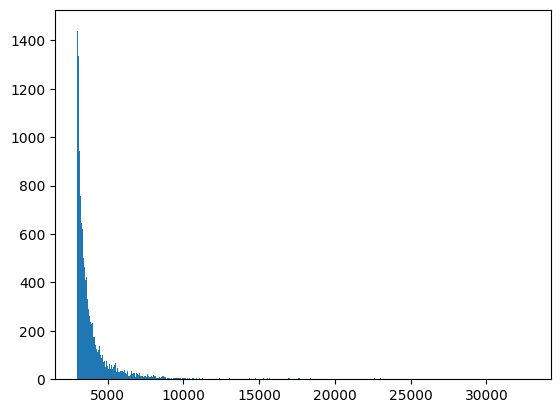

In [84]:
plt.hist(img_to_crop.flatten(), bins=10000, range=[3000, 2**15])

In [2]:
#random sampling di img and img to crop7
import numpy as np

# Supponiamo che 'points' sia un array numpy di forma (N, 3)
img = img.flatten()

img = np.array([img])  # Inserisci i tuoi punti qui
print("a")

# Numero di punti originali
N = img.shape[0]

# Numero di punti da mantenere (ridotto di un fattore 1000)
num_points_to_keep = N // 1000

# Campionamento efficiente
sampled_indices = random.sample(range(N), num_points_to_keep)

# Utilizza un generatore per iterare sui punti selezionati senza creare una nuova lista in memoria
sampled_points = (img[i] for i in sampled_indices)

: 

In [ ]:
img_to_crop = img_to_crop.flatten() 

# Numero di punti originali
N = img_to_crop.shape[0]

# Numero di punti da mantenere (ridotto di un fattore 1000)
num_points_to_keep = N // 1000

# Campionamento casuale dei punti
sampled_indices = np.random.choice(N, num_points_to_keep, replace=False)
img_to_crop = img_to_crop[sampled_indices]

In [4]:
from sklearn.neighbors import KernelDensity
import numpy as np


filtered_points_image1 = img[(img >= 500) & (img <= 2**15)]
kde1 = KernelDensity(bandwidth=10).fit(filtered_points_image1)
print("kde done")
log_density1 = kde1.score_samples(filtered_points_image1)


def objective(xmax2):
    filtered_points_image2 = img_to_crop[(img_to_crop >= 500) & (img_to_crop <= xmax2)]
    kde2 = KernelDensity(bandwidth=10).fit(filtered_points_image2)
    print("kde 2 done")
    log_density2 = kde2.score_samples(filtered_points_image1)  # Notare che usi points_image1 per coerenza
    
    kl_divergence = np.sum(np.exp(log_density1) * (log_density1 - log_density2))
    return kl_divergence

from scipy.optimize import minimize

# Supponi che xmax2 iniziale sia xmax_possible iniziale
result = minimize(objective, x0=2**12, bounds=[(2**11, 2**14)])
optimal_xmax2 = result.x

: 

In [ ]:
img_to_crop = img_to_crop.max(0)

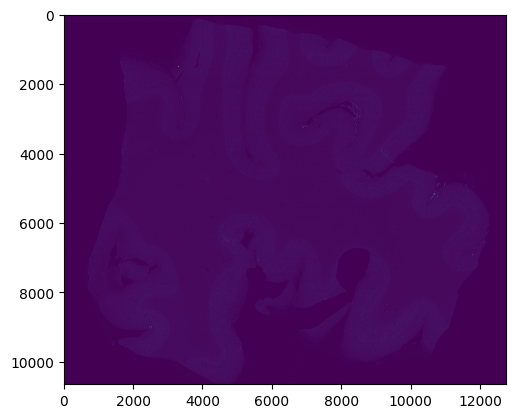

In [73]:
plt.imshow(img_to_crop, vmin=0, vmax=2**15)

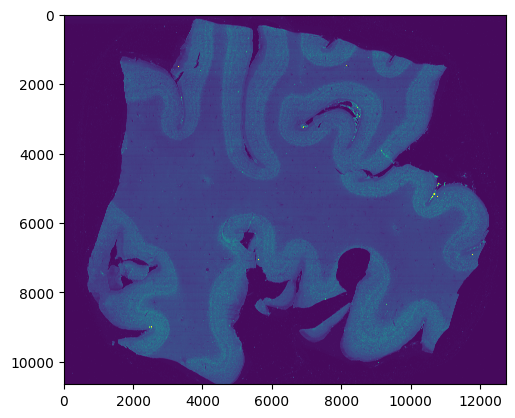

In [76]:
plt.imshow(img_to_crop, vmin=0, vmax=2**12)

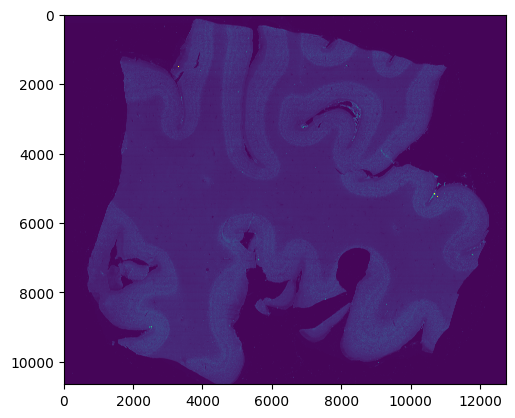

In [77]:
plt.imshow(img_to_crop, vmin=0, vmax=2**13)